In [ ]:
import os
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Allocated GB:", torch.cuda.memory_allocated() / 1e9)

torch.backends.cudnn.benchmark = True

DATA_ROOT = Path(r"E:\University\FS2025\Scientific Writing\Project\FFPP_processed_temporal")

REAL_DIR = DATA_ROOT / "original"

FAKE_TRAINVAL_DIRS = [
    DATA_ROOT / "Deepfakes",
    DATA_ROOT / "Face2Face",
    DATA_ROOT / "FaceShifter",
    DATA_ROOT / "FaceSwap",
    DATA_ROOT / "NeuralTextures",
]

FAKE_TEST_DIR = DATA_ROOT / "DeepFakeDetection"

SEQ_LEN = 16

IMG_H, IMG_W = 224, 224
BATCH_SIZE = 16
EPOCHS = 25

N_TRAIN_REAL, N_TRAIN_FAKE = 9000, 9000
N_VAL_REAL,   N_VAL_FAKE   = 3900, 3900
N_TEST_REAL,  N_TEST_FAKE  = 3200, 3200

Using device: cuda
NVIDIA GeForce RTX 3060 Ti
Allocated GB: 0.0


In [ ]:
def list_sequence_folders(root: Path):
    if not root.exists():
        raise FileNotFoundError(f"Missing folder: {root}")
    return sorted([p for p in root.iterdir() if p.is_dir()])

real_seqs = list_sequence_folders(REAL_DIR)

fake_trainval_seqs = []
for d in FAKE_TRAINVAL_DIRS:
    fake_trainval_seqs.extend(list_sequence_folders(d))

fake_test_seqs = list_sequence_folders(FAKE_TEST_DIR)

print("Available sequences:")
print(" real:", len(real_seqs))
print(" fake train/val mix:", len(fake_trainval_seqs))
print(" fake test (DeepFakeDetection):", len(fake_test_seqs))


def sample_with_oversample(items, n, seed=SEED):
    rng = random.Random(seed)
    if len(items) == 0:
        raise ValueError("No items available to sample from.")
    if len(items) >= n:
        return rng.sample(items, n)
    return [rng.choice(items) for _ in range(n)]

real_train = sample_with_oversample(real_seqs, N_TRAIN_REAL, seed=SEED + 1)
real_val   = sample_with_oversample(real_seqs, N_VAL_REAL,   seed=SEED + 2)
real_test  = sample_with_oversample(real_seqs, N_TEST_REAL,  seed=SEED + 3)

fake_train = sample_with_oversample(fake_trainval_seqs, N_TRAIN_FAKE, seed=SEED + 4)
fake_val   = sample_with_oversample(fake_trainval_seqs, N_VAL_FAKE,   seed=SEED + 5)

fake_test  = sample_with_oversample(fake_test_seqs, N_TEST_FAKE, seed=SEED + 6)

train_items = [(p, 0) for p in real_train] + [(p, 1) for p in fake_train]
val_items   = [(p, 0) for p in real_val]   + [(p, 1) for p in fake_val]
test_items  = [(p, 0) for p in real_test]  + [(p, 1) for p in fake_test]

random.shuffle(train_items)
random.shuffle(val_items)
random.shuffle(test_items)

print("Final sizes:")
print(" train:", len(train_items), "val:", len(val_items), "test:", len(test_items))

Available sequences:
 real: 1000
 fake train/val mix: 5000
 fake test (DeepFakeDetection): 1000
Final sizes:
 train: 18000 val: 7800 test: 6400


In [ ]:
def _list_frame_files(folder: Path):
    return sorted([
        p for p in folder.iterdir()
        if p.suffix.lower() in [".jpg", ".jpeg", ".png"]
    ])


def load_sequence_numpy(folder: Path, seq_len: int = SEQ_LEN):
    frame_files = _list_frame_files(folder)

    if len(frame_files) == 0:
        return np.zeros((seq_len, IMG_H, IMG_W, 3), dtype=np.uint8)

    if len(frame_files) < seq_len:
        reps = (seq_len + len(frame_files) - 1) // len(frame_files)
        frame_files = (frame_files * reps)[:seq_len]
    else:
        frame_files = frame_files[:seq_len]

    frames = []
    for fp in frame_files:
        img = Image.open(fp).convert("RGB")
        img = img.resize((IMG_W, IMG_H))
        frames.append(np.array(img))

    return np.stack(frames).astype(np.uint8)


class SequenceDataset(Dataset):
    def __init__(self, items, seq_len=SEQ_LEN, img_size=(IMG_H, IMG_W), training=False):
        self.items = items
        self.seq_len = seq_len
        self.img_size = img_size
        self.training = training

        self.base_transform = T.Compose([
            T.Resize(self.img_size),
            T.ToTensor(),  # [0,1]
        ])

    def __len__(self):
        return len(self.items)

    def _load_sequence_tensor(self, folder: Path):
        frame_files = _list_frame_files(folder)

        if len(frame_files) == 0:
            return torch.zeros(self.seq_len, 3, self.img_size[0], self.img_size[1], dtype=torch.float32)

        if len(frame_files) < self.seq_len:
            reps = (self.seq_len + len(frame_files) - 1) // len(frame_files)
            frame_files = (frame_files * reps)[:self.seq_len]
        else:
            frame_files = frame_files[:self.seq_len]

        frames = []
        for fp in frame_files:
            img = Image.open(fp).convert("RGB")
            img = self.base_transform(img)  
            frames.append(img)

        frames = torch.stack(frames, dim=0)  
        if self.training:

            if random.random() < 0.5:
                frames = torch.flip(frames, dims=[3])  
            delta = (random.random() * 0.4) - 0.2  
            frames = torch.clamp(frames + delta, 0.0, 1.0)

        return frames

    def __getitem__(self, idx):
        folder, label = self.items[idx]
        folder = Path(folder)
        frames = self._load_sequence_tensor(folder)
        label = int(label)
        return frames, label

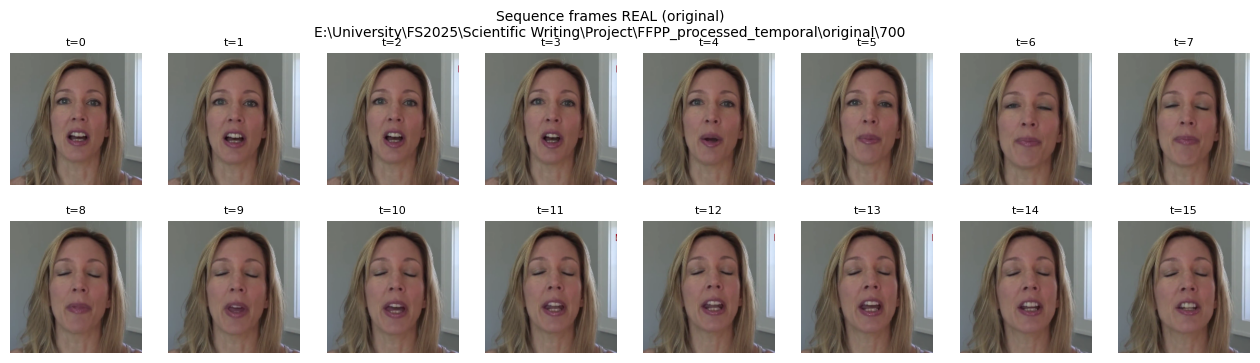

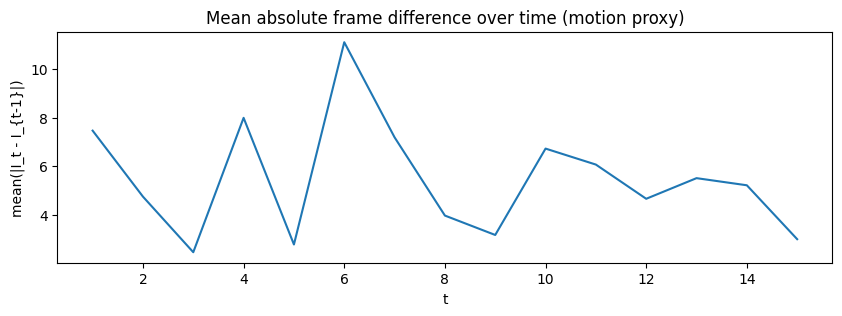

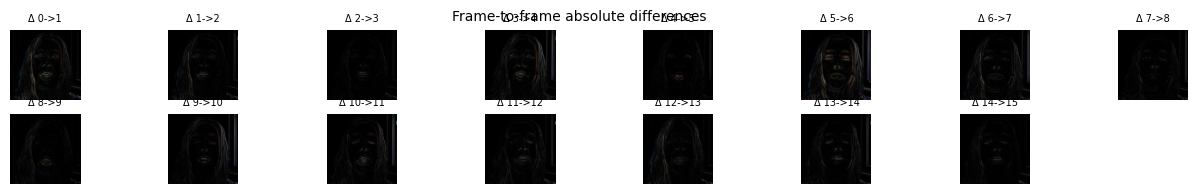

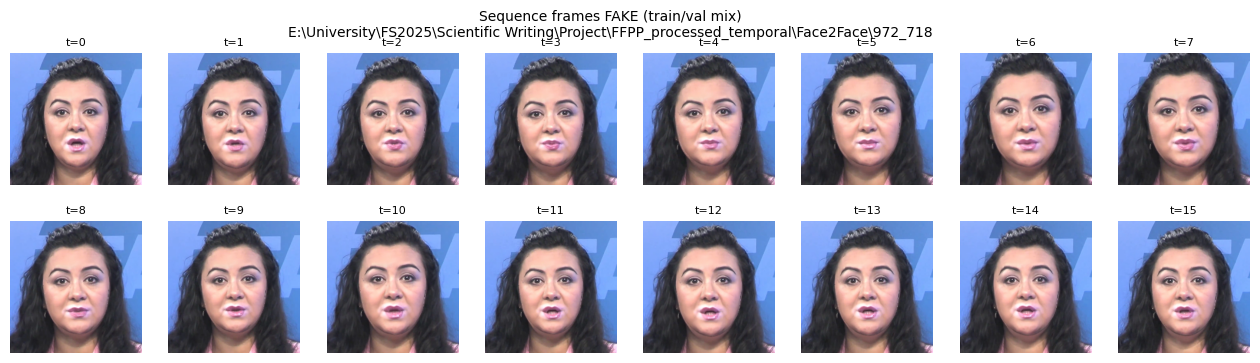

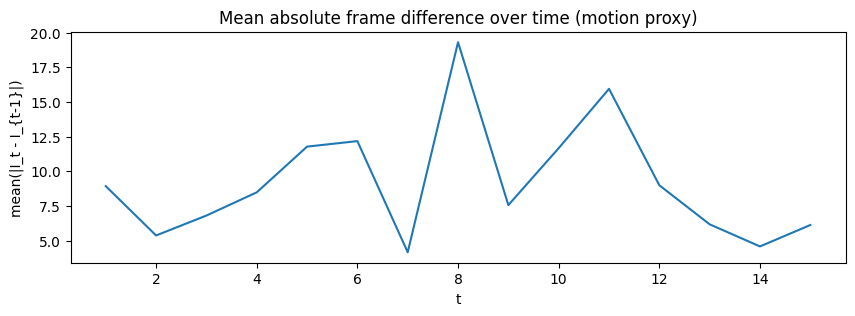

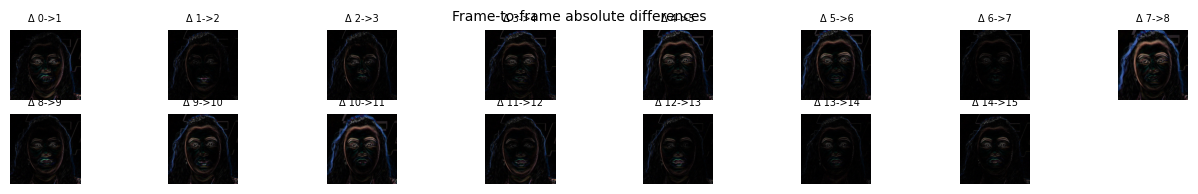

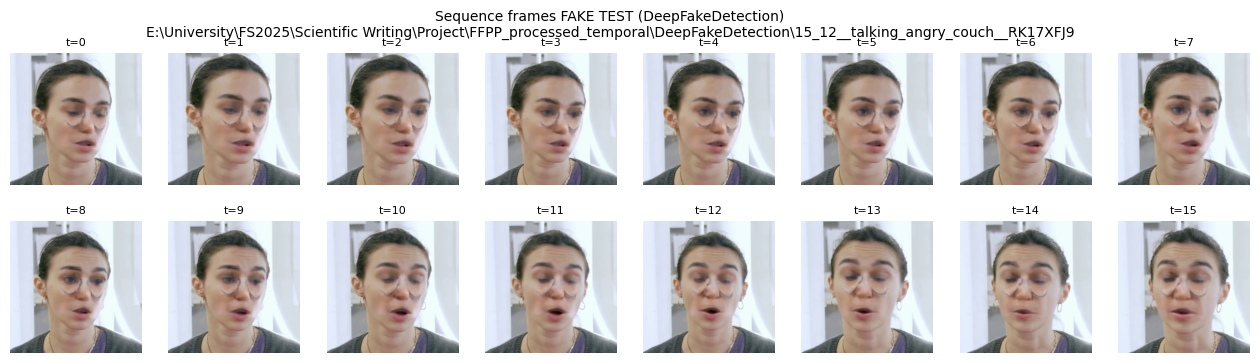

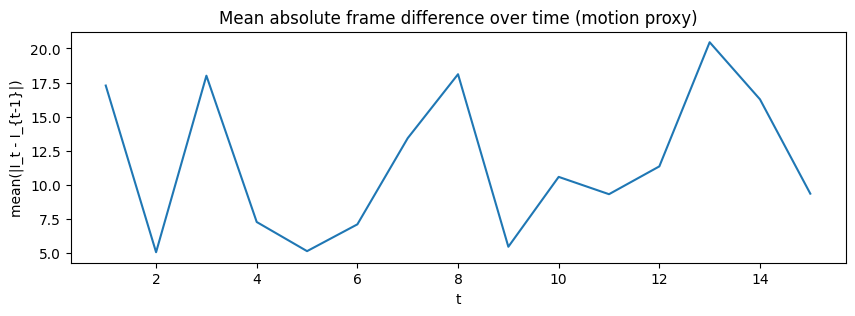

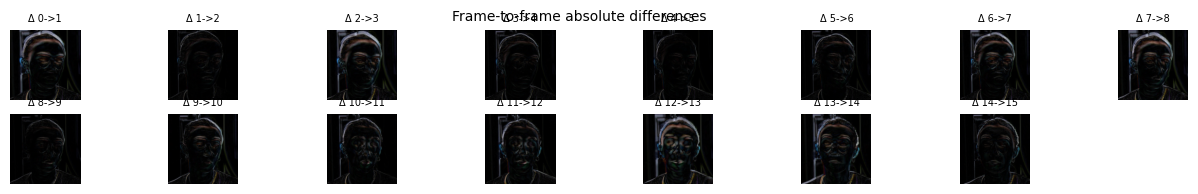

In [ ]:
def visualize_sequence(folder: Path, title=""):
    frames = load_sequence_numpy(folder)

    # 1) Grid of frames (bigger, no per-frame captions)
    cols = 8
    rows = int(np.ceil(SEQ_LEN / cols))
    plt.figure(figsize=(20, 5))
    for i in range(SEQ_LEN):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(frames[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    # 2) Frame-to-frame absolute differences (bigger, no per-frame captions)
    plt.figure(figsize=(20, 4))
    for t in range(1, SEQ_LEN):
        d = np.abs(frames[t].astype(np.int16) - frames[t - 1].astype(np.int16)).astype(np.uint8)
        ax = plt.subplot(2, 8, t)
        ax.imshow(d)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


random_real = random.choice(real_seqs)
random_fake_train = random.choice(fake_trainval_seqs)
random_fake_test = random.choice(fake_test_seqs)

visualize_sequence(random_real, "REAL (original)")
visualize_sequence(random_fake_train, "FAKE (train/val mix)")
visualize_sequence(random_fake_test, "FAKE TEST (DeepFakeDetection)")

In [ ]:
train_dataset = SequenceDataset(train_items, seq_len=SEQ_LEN, img_size=(IMG_H, IMG_W), training=True)
val_dataset = SequenceDataset(val_items, seq_len=SEQ_LEN, img_size=(IMG_H, IMG_W), training=False)
test_dataset = SequenceDataset(test_items, seq_len=SEQ_LEN, img_size=(IMG_H, IMG_W), training=False)

nw = 0 if os.name == "nt" else 8
pin = (device.type == "cuda")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=nw,
    pin_memory=pin,
    persistent_workers=(nw > 0),
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=nw,
    pin_memory=pin,
    persistent_workers=(nw > 0),
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=nw,
    pin_memory=pin,
    persistent_workers=(nw > 0),
)

steps_per_epoch = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

print("Steps:", steps_per_epoch, val_steps, test_steps)

Steps: 1125 488 400


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models


class VGG16LSTM(nn.Module):
    def __init__(self, seq_len=SEQ_LEN):
        super().__init__()
        self.seq_len = seq_len

        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg.features 

        for param in self.features.parameters():
            param.requires_grad = False
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        feature_dim = 512  

        self.lstm = nn.LSTM(input_size=feature_dim, hidden_size=256, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        b, t, c, h, w = x.shape
        x = x.view(b * t, c, h, w)
        x = self.features(x)
        x = self.pool(x)  
        x = x.view(b, t, -1)  

        x, _ = self.lstm(x) 
        x = x[:, -1, :]     
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


model = VGG16LSTM(seq_len=SEQ_LEN).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

print(model)

VGG16LSTM(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

In [ ]:
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


def run_epoch(loader, model, optimizer=None):
    is_train = optimizer is not None
    model.train(mode=is_train)
    running_loss = 0.0
    running_correct = 0
    total = 0

    for sequences, labels in loader:
        sequences = sequences.to(device, non_blocking=True)  
        labels = labels.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            outputs = model(sequences)
            loss = criterion(outputs, labels)

        if is_train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * labels.size(0)
        running_correct += outputs.argmax(1).eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
best_state = None

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    train_loss, train_acc = run_epoch(train_loader, model, optimizer)
    val_loss, val_acc = run_epoch(val_loader, model, optimizer=None)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"  Train loss: {train_loss:.4f}  acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f}  acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
        }
        torch.save(best_state, "vgg16_lstm_best.pth")
        print("  Saved new best model.")

if best_state is not None:
    model.load_state_dict(best_state["model"])

Epoch 1/25
  Train loss: 0.6884  acc: 0.5374
  Val   loss: 0.6817  acc: 0.5640
  Saved new best model.
Epoch 2/25
  Train loss: 0.6717  acc: 0.5805
  Val   loss: 0.6638  acc: 0.5946
  Saved new best model.
Epoch 3/25
  Train loss: 0.6518  acc: 0.6155
  Val   loss: 0.6520  acc: 0.6137
  Saved new best model.
Epoch 4/25
  Train loss: 0.6366  acc: 0.6374
  Val   loss: 0.6363  acc: 0.6247
  Saved new best model.
Epoch 5/25
  Train loss: 0.6172  acc: 0.6556
  Val   loss: 0.6235  acc: 0.6340
  Saved new best model.
Epoch 6/25
  Train loss: 0.5974  acc: 0.6722
  Val   loss: 0.6120  acc: 0.6519
  Saved new best model.
Epoch 7/25
  Train loss: 0.5727  acc: 0.6907
  Val   loss: 0.5898  acc: 0.6704
  Saved new best model.
Epoch 8/25
  Train loss: 0.5440  acc: 0.7116
  Val   loss: 0.5811  acc: 0.6788
  Saved new best model.
Epoch 9/25
  Train loss: 0.5150  acc: 0.7368
  Val   loss: 0.5499  acc: 0.7113
  Saved new best model.
Epoch 10/25
  Train loss: 0.4867  acc: 0.7608
  Val   loss: 0.4901  acc: 

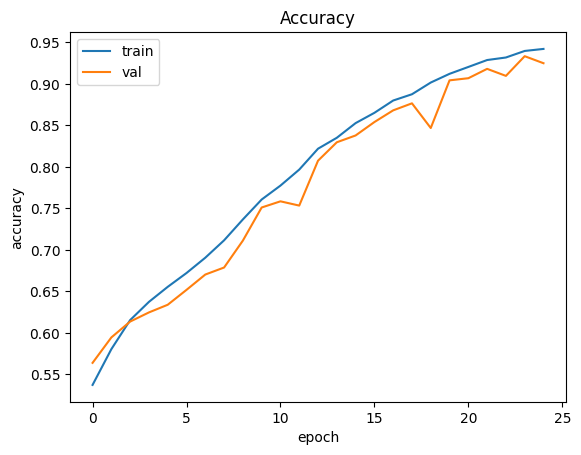

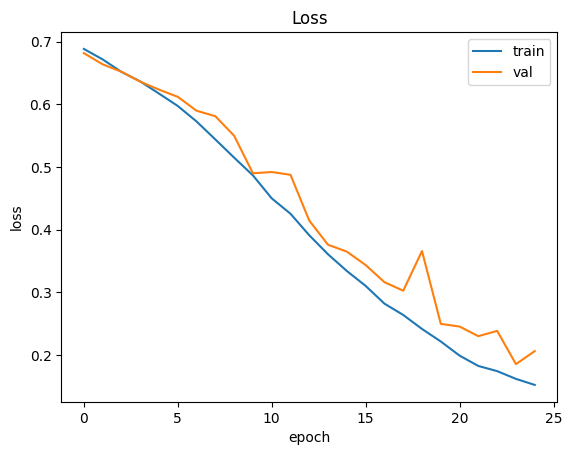

In [ ]:

plt.figure()
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title("Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "val"])
plt.show()

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "val"])
plt.show()

Test accuracy: 0.866875
Test loss: 0.43257971029379405


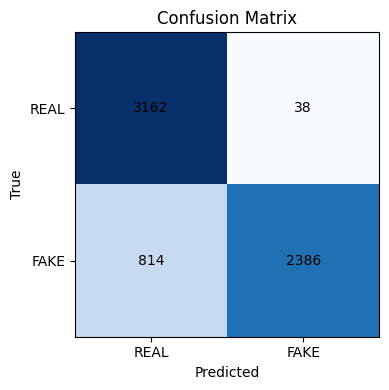


Final test metrics ->  Accuracy: 0.8669  |  Loss: 0.4326


In [ ]:

from sklearn.metrics import confusion_matrix

model.eval()
all_preds = []
all_labels = []
all_losses = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(sequences)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_losses.append(loss.item() * labels.size(0))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

cm = confusion_matrix(all_labels, all_preds)

test_accuracy = (all_preds == all_labels).mean()
num_test_samples = len(all_labels)
test_loss = sum(all_losses) / num_test_samples

print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0, 1], ["REAL", "FAKE"])
plt.yticks([0, 1], ["REAL", "FAKE"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", color="black")
plt.tight_layout()
plt.show()

print("\nFinal test metrics ->  Accuracy: {:.4f}  |  Loss: {:.4f}".format(test_accuracy, test_loss))